# Convolutional Neural Networks

Let's look at how to implement a Convolutional Neural Network in pytorch, and investigate an example case based on a solid state physics problem.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from os.path import exists
import time
import seaborn as sns

import torch.nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data

We discussed the Ising Model in class -- let's imagine we have a lattice of spins, which can have values $\pm1$, and we make measurements of different lattices at different temperatures.  We'll import that dataset and use the first 20k samples as training events.

In [27]:
output = 'ising_data.npz'

if not exists(output):
    import gdown
    url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1Ihxt1hb3Kyv0IrjHlsYb9x9QY7l7n2Sl"
    gdown.download(url, output, quiet=True)

f = np.load(output, allow_pickle=True)
n_train = 20000
n_test=len(f["C"])-n_train

x_train, x_test = f["C"][:n_train], f["C"][n_train:]
T_train, T_test = f["T"][:n_train], f["T"][n_train:]

Let's take a quick look at some of the samples to see what they look like: each sample is composed of a 2D grid of 32x32 pixels (each pixel can be +1 or -1) and corresponds to the lattice at a given temperature:

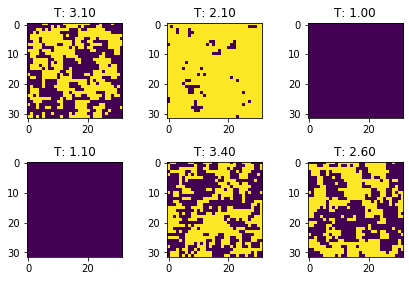

In [28]:
for i,j in enumerate(np.random.choice(n_train, 6)):
    plt.subplot(2,3,i+1)
    image = x_train[j]
    if j==1:
        print(image)
    plot = plt.imshow(image)
    plt.title("T: %.2f" % T_train[j])

plt.tight_layout()
plt.show()

Text(0, 0.5, 'frequency')

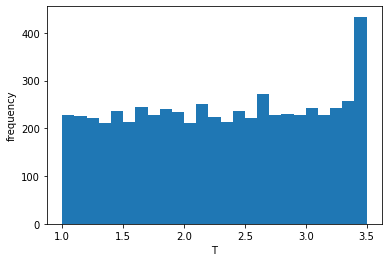

In [29]:
plt.hist(T_test,bins=25)
plt.xlabel("T")
plt.ylabel("frequency")

We can see that the temperature data is somewhat discrete, and only measured to two significant figures:

In [30]:
print(T_test[0:10])

[2.1 1.8 3.4 2.2 2.8 2.9 2.4 1.6 2.9 1.2]


We'll define our critical temperature, at which the phase transition takes place, at 2.27 (in some units).  Then we can label each image with a 1 or a 0 based on whether the associated temperature is above or below that critical temperature:

In [31]:
Tc = 2.27
y_train, y_test = T_train > Tc, T_test > Tc
y_train = np.multiply(y_train,1)
y_test = np.multiply(y_test,1)

## Training a Fully Connected Net

We'll start by passing the full image into a fully-connected neural network.  To do this, we need to reformat the image from a 2D array of 32x32 pixels into a 1D array of (32\*32=1024) pixels.  (Technically, we have a 3D array of dimensions [n_events, width, height] that we want to transform into [n_events, width\*height].)  The "y" labels are just a single number corresponding to whether the system is above the critical temperature or not.

In [32]:
x_train=np.reshape(x_train,(n_train,32*32))
x_test=np.reshape(x_test,(n_test,32*32))
y_train=np.reshape(y_train,(n_train,1))
y_test=np.reshape(y_test,(n_test,1))

Now we construct a fully-connected network like normal, with 32\*32 input features, two hidden layers with 32 nodes each, and an output layer with a single node, which will tell us whether the network thinks a phase transition has already occurred for a given image:

In [33]:
torch.manual_seed(123)
net = torch.nn.Sequential(
    torch.nn.Linear(32*32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
)
print(net)
np.sum([np.prod(theta.shape) for theta in net.parameters()])

Sequential(
  (0): Linear(in_features=1024, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)


33889

The network has 34k free parameters.  This is a binary classification problem, so we use the Binary Cross Entropy (BCE) loss function, along with a sigmoid activation function, which is all wrapped up in the `BCEWithLogitsLoss` loss function:

In [34]:
loss_fn = torch.nn.BCEWithLogitsLoss()

We'll now do the usual training.  We use the `Adam` optimizer, and 5 batches.  Note that with 20k training samples, using 5 batches means 4k events per batch, which is a lot when running on a CPU.  So this could certainly be optimized!

We'll also keep track of how long each epoch takes as we go through the training, just to have a sense for how long it takes to train this model.

In [10]:
net.train()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
losses = []
losses_test = []

x_train_tensor=torch.tensor(x_train)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)
xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(x_train)/5), shuffle=True)

x_test_tensor=torch.tensor(x_test,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

for epoch in range(20):
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=loss_fn(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

Completed epoch  0 in  0.3s, Train loss=5.1e-01, Test loss=4.8e-01
Completed epoch  1 in  0.2s, Train loss=4.9e-01, Test loss=6.9e-01
Completed epoch  2 in  0.2s, Train loss=5.6e-01, Test loss=4.5e-01
Completed epoch  3 in  0.2s, Train loss=3.3e-01, Test loss=3.0e-01
Completed epoch  4 in  0.2s, Train loss=2.4e-01, Test loss=2.3e-01
Completed epoch  5 in  0.2s, Train loss=1.6e-01, Test loss=1.5e-01
Completed epoch  6 in  0.2s, Train loss=1.1e-01, Test loss=1.1e-01
Completed epoch  7 in  0.2s, Train loss=9.1e-02, Test loss=9.0e-02
Completed epoch  8 in  0.2s, Train loss=9.3e-02, Test loss=8.5e-02
Completed epoch  9 in  0.2s, Train loss=8.8e-02, Test loss=8.6e-02
Completed epoch 10 in  0.2s, Train loss=7.5e-02, Test loss=8.3e-02
Completed epoch 11 in  0.2s, Train loss=7.0e-02, Test loss=8.2e-02
Completed epoch 12 in  0.2s, Train loss=6.1e-02, Test loss=8.1e-02
Completed epoch 13 in  0.2s, Train loss=6.4e-02, Test loss=8.1e-02
Completed epoch 14 in  0.2s, Train loss=6.0e-02, Test loss=8.0

Let's take a look at the loss function and see how well the training went:

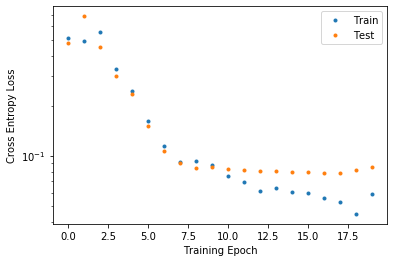

In [11]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

Pretty good!  We converged on a good configuration within about 5 epochs, with a minimum of the loss function around 9e-2.  

It would also be interesting to evaluate the performance of the net in terms of the accuracy of the predictions:

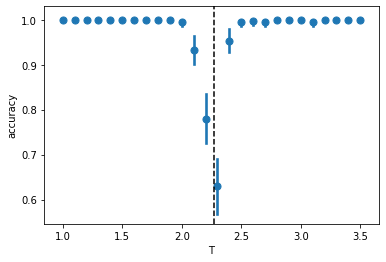

In [12]:
y_pred = torch.sigmoid(net(x_test_tensor).detach()).round().tolist()
acc = (y_pred == y_test).astype(np.float)

ax = sns.regplot(x=T_test, y=acc, x_estimator= np.mean, fit_reg=False)
ax.set_ylabel("accuracy")
ax.set_xlabel("T")
plt.axvline(x=Tc, color='k', linestyle='--', label='Tc')

We see that the classifier has an easy time with samples well below or well above the critical temperature, and dips down to around 60\% accuracy right at the critical temperature.

## Using a Convolutional Neural Net

Now let's do this with a convolutional neural net (CNN), where we pass in the image as a 2D array, and use convolutional filters to pick out features of the images.

We'll implement a standard CNN for classification.  This involves some convolutional layers, which then feed into a fully connected network that does the final classification at the end.  Since we have this mixed structure, we can't just implement this in pytorch's `Sequential` module like we normally do, since we'll need to "flatten" the data from a multi-dimensional structure coming out of the CNN into a lower-dimensional structure for processing by the fully connected network.  So we make use of pytorch's `Module` base class to implement our own type of network.

In [35]:
torch.manual_seed(123)
class Net(torch.nn.Module):
    def __init__(self, conv_layer_size=16, linear_layer_size=32):
        super(Net, self).__init__()

        lls=linear_layer_size
        cls=conv_layer_size
        
        # two convolutional layers
        self.conv1 = torch.nn.Conv2d(  1, cls, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(cls, lls, kernel_size=3, padding=1)

        # fully connected layer
        self.fc1 = torch.nn.Linear(lls, 1)

    # x represents our data
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        # if we wanted to add another layer before pooling, we could do that here.

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        
        # we could also do some dropout here if we wanted

        x = self.conv2(x)
        x = F.relu(x)

        # perhaps we want another layer here?

        # the (1,1) makes this into global average pooling
        x = F.adaptive_avg_pool2d(x,(1,1))
    
        # Flatten x with start_dim=1, i.e. only keep one number per channel per event.
        # This one line kept me up into the wee hours the other night!
        x=torch.flatten(x,1)
      
        # Pass data through the fully connected layer.
        x = self.fc1(x)

        return x

We see above that after the first convolutional layer, we do a "max repooling" to reduce the size of the feature map that's passed in as the input to the second convolutional layer.  

After the second convolutional layer, we do a "global average pooling", which reduces all the pixels in each channel of the current feature map into a single number (the average).  Note that the original input image had a single channel (gray, no rgb) but the first convolutional layer includes a number of filters, where each filter creates a new channel in the output feature map.  So by the end of the convolutional layers, we have transformed our `[1, 32, 32]` inputs into `[lls, 16, 16]` inputs, where `lls` represents the number of inputs to the fully connected network after the convolutional layers.  (Why 16?)  The global average pooling then takes that `[lls, 16, 16]` output and transforms it into `[lls, 1, 1]`.

The flattening step takes the `[lls, 1, 1]` tensor in the output feature map into a list with dimension `[lls]`.

Now we can prepare our data to pass into this network.  The tensors we extract from the input data have dimensions `[nevents, width, height]`, while pytorch CNN's expect tensors with dimensions `[nevents, channels, width, height]`.  In our case we only have a single channel, but we still need to indicate that as a separate dimension in the tensor.  We'll do that using the `unsqueeze` operation, where we add in a dimension of unit length at the specified index of the tensor dimensions.

In [14]:
x_train, x_test = f["C"][:n_train], f["C"][n_train:]
T_train, T_test = f["T"][:n_train], f["T"][n_train:]

x_train_tensor=torch.tensor(x_train,dtype=torch.float)
x_train_tensor=x_train_tensor.unsqueeze(1)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test,dtype=torch.float)
x_test_tensor=x_test_tensor.unsqueeze(1)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)

We can now construct our network, and check how many parameters are in this network.  Let's make the first convolutional layer a 2-stage filter, while the second one will have 16 filters to give us plenty of inputs for our fully connected network. 

In [24]:
net = Net(2,16)
print(net)
print(np.sum([np.prod(theta.shape) for theta in net.parameters()]))

16 2
Net(
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16, out_features=1, bias=True)
)
341


Now we'll train our network, keeping the same hyperparameters as with the fully-connected network above, but now using the new network architecture.

In [16]:
net.train()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
losses = []
losses_test = []

loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(x_train)/5), shuffle=True)

for epoch in range(20):
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=loss_fn(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

Completed epoch  0 in  4.2s, Train loss=6.7e-01, Test loss=6.7e-01
Completed epoch  1 in  3.2s, Train loss=6.0e-01, Test loss=5.9e-01
Completed epoch  2 in  3.0s, Train loss=5.0e-01, Test loss=4.6e-01
Completed epoch  3 in  3.2s, Train loss=3.6e-01, Test loss=3.3e-01
Completed epoch  4 in  3.0s, Train loss=2.7e-01, Test loss=2.4e-01
Completed epoch  5 in  3.0s, Train loss=2.2e-01, Test loss=2.0e-01
Completed epoch  6 in  3.2s, Train loss=1.7e-01, Test loss=1.6e-01
Completed epoch  7 in  3.1s, Train loss=1.4e-01, Test loss=1.3e-01
Completed epoch  8 in  3.0s, Train loss=1.2e-01, Test loss=1.1e-01
Completed epoch  9 in  3.0s, Train loss=1.0e-01, Test loss=9.5e-02
Completed epoch 10 in  3.2s, Train loss=8.9e-02, Test loss=8.2e-02
Completed epoch 11 in  3.1s, Train loss=8.1e-02, Test loss=7.2e-02
Completed epoch 12 in  3.0s, Train loss=7.1e-02, Test loss=6.4e-02
Completed epoch 13 in  3.0s, Train loss=6.9e-02, Test loss=5.9e-02
Completed epoch 14 in  3.0s, Train loss=6.3e-02, Test loss=5.4

Woah, why is this so slow?  With our fully-connected model using 33889 parameters, we saw much shorter training times.  The CNN is much longer, even though we have x100 fewer parameters.  What happened?

The process of convolving the input with the filter is actually quite computationally expensive, since computing each cell of the feature layer requires iterating over a neighborhood of cells in the input.  

We can compute the number of multiplication operations in the first convolution layer as:
* 1 x 2 = number of operations for all the channels (input channels * output channels)
* 32 x 32 = number of convolution operation per channel (image size)
* 3 x 3 = number of multiplications per convolution (kernel size)
    
The total is then (1x2)x(32x32)x(3x3)=18432 operations.  For the second convolutional layer it's (2x16)x(16x16)x(3x3)=73728 operations.  Finally, the fully connected layer at the end corresponds to 16x1=16 operations.  So the total is around 100k multiplication operations.  (This is ignoring the the bias terms, so these numbers aren't exact.)

For the fully-connected MLP at the beginning, we used 1024 inputs, two hidden layers of 32 nodes, and a single output node.  So that's 1024x32 + 32x32 + 32x1 = 33824, or around 34k multiplication operations.

So just from the number of multiplication operations we expect the fully-connected MLP to be around x3 faster than the CNN, despite having significantly fewer parameters.  Additional overhead from pooling and flattening further increases the run time of the CNN.  Finally, the multiplication operations for the MLP are all performed using matrix algebra, and there are libraries that make such operations extremely fast to compute using modern computer architectures.  The kernel-based convolution is more of an elementwise-matrix-multiplication that is not the same as a pure matrix multiplication, and hence is not as optimized.  

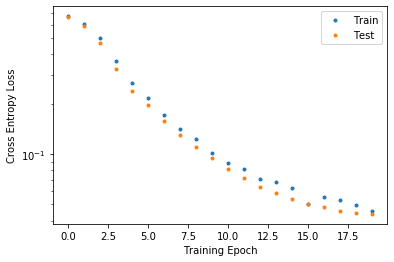

In [17]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

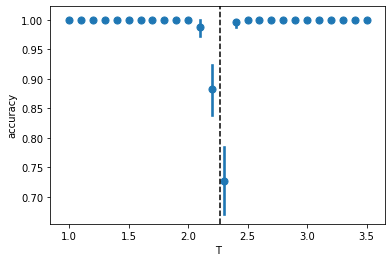

In [18]:
y_pred = torch.sigmoid(net(x_test_tensor).detach()).round().tolist()
acc = (y_pred == y_test).astype(np.float)

ax = sns.regplot(x=T_test, y=acc, x_estimator= np.mean, fit_reg=False)
ax.set_ylabel("accuracy")
ax.set_xlabel("T")
plt.axvline(x=Tc, color='k', linestyle='--', label='Tc')

**Exercise**: add in another convolutional layer and re-run.  How does it impact the loss function or accuracy of the predictions?  How does it impact the training times?

**Exercise**: modify the code above (or copy/modify it below) to predict the temperature rather than a classification label.  

## Hardware Accelerators

The model above implements a network that only has two convolutional layers.  What if we wanted to add more: 4, or 8, or >10?  What if we wanted to increase the number of feature map channels to >100?  The training times will start to explode, even on the fast CPU that I'm using for lecture today.  At that point we need to use different hardware if we want to get results in a reasonable amount of time.

The most common way to accelerate training times is to use Graphical Processing Units (GPUs).  GPUs are designed to render graphics on screens, and thus perform many (hundreds, thousands) computations in parallel, while CPU's excel in performing fast calculations sequentially.  Since fast matrix algebra is all about parallelization, using a GPU to train a NN can significantly decrease training times.

I happen to have a pretty-good GPU in a machine in my office:

In [19]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Let's use our GPU to re-train the network above, and see how it affects training times:

In [20]:
if torch.cuda.is_available():
    net = Net(2,16)
    print(net)
    print(np.sum([np.prod(theta.shape) for theta in net.parameters()]))

    net.train()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    losses = []
    losses_test = []

    # we need to send the network and data to the GPU!
    net.to(device)
    x_train_tensor=x_train_tensor.to(device)
    y_train_tensor=y_train_tensor.to(device)
    x_test_tensor=x_test_tensor.to(device)
    y_test_tensor=y_test_tensor.to(device)

    # recreate the TensorDataset and Loader with the data on the GPU
    xy_train = torch.utils.data.TensorDataset(x_train_tensor,y_train_tensor)
    loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(x_train)/5), shuffle=True)

    for epoch in range(20):
        start_time = time.time()
        for x_batch, y_batch in loader:
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
        net.eval() # configure the model for evaluation (testing)
        y_pred = net(x_test_tensor)
        test_loss=loss_fn(y_pred, y_test_tensor)
        losses_test.append(test_loss.data)
        end_time=time.time()
        elapsed_time = end_time - start_time
        print("Completed epoch %2d in %4.2fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

The training times dropped significantly!  Just to make sure it's learning something real, let's confirm by checking the loss and accuracy again:

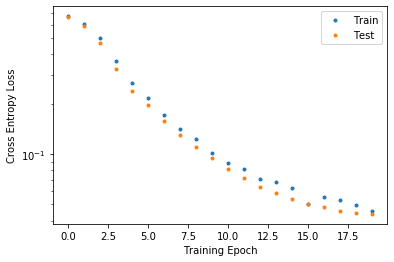

In [21]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

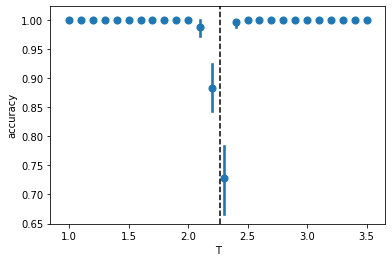

In [22]:
y_pred = torch.sigmoid(net(x_test_tensor).detach()).round().tolist()
acc = (y_pred == y_test).astype(np.float)

ax = sns.regplot(x=T_test, y=acc, x_estimator= np.mean, fit_reg=False)
ax.set_ylabel("accuracy")
ax.set_xlabel("T")
plt.axvline(x=Tc, color='k', linestyle='--', label='Tc')